In [2]:
# histogram of a grayscale image

import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
testImagePaths = ['/Users/nuhash/Downloads/test18_50_25.PNG' ]

772 1353 1728 2052


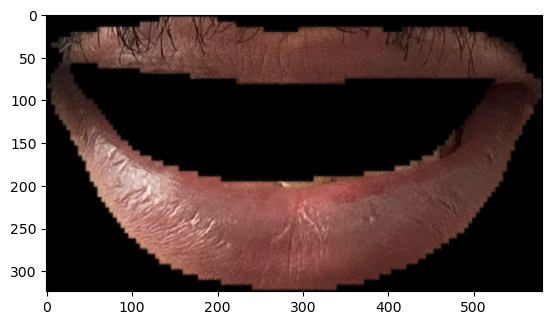

In [4]:
image = cv2.imread(testImagePaths[0], cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
left = -1
right = -1
top = -1
bottom = -1

for i in range(image.shape[0]):
    if np.any(image[i] > 0):
        top = i
        break
for i in range(image.shape[0] - 1, -1, -1):
    if np.any(image[i] > 0):
        bottom = i
        break
for i in range(image.shape[1]):
    if np.any(image[:, i] > 0):
        left = i
        break
for i in range(image.shape[1] - 1, -1, -1):
    if np.any(image[:, i] > 0):
        right = i
        break
print(left, right, top, bottom)
image = image[top:bottom, left:right]
plt.imshow(image)
plt.show()

In [5]:
def runKernel(half_kernel_size, frame_width, rotation):
    sample_step = 1.0 / frame_width
    outputImage = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            max_of_y = 0.0
            min_of_y = 5566.0
            for k in range(-half_kernel_size, half_kernel_size + 1):
                if rotation == 0 or rotation == 180:
                    sample_shift = np.array([0.0, float(k) * sample_step])
                else:
                    sample_shift = np.array([float(k) * sample_step, 0.0])
                x = j + sample_shift[0]
                y = i + sample_shift[1]
                if x < 0 or x >= image.shape[1] or y < 0 or y >= image.shape[0]:
                    continue
                color = image[int(y), int(x)]
                gray = 0.299 * color[0] + 0.587 * color[1] + 0.114 * color[2]
                max_of_y = max(gray, max_of_y)
                min_of_y = min(gray, min_of_y)
            outputImage[i, j] = [max_of_y, min_of_y, 0]
    plt.imshow(outputImage[:, :, 0], cmap='gray')
    plt.title('half_kernel_size: {}, frame_width: {}, rotation: {}'.format(half_kernel_size, frame_width, rotation))
    # plt.imshow(outputImage)
    plt.show()
    plt.imshow(outputImage[:, :, 1], cmap='gray')
    plt.title('half_kernel_size: {}, frame_width: {}, rotation: {}'.format(half_kernel_size, frame_width, rotation))
    # plt.imshow(outputImage)
    plt.show()
    
    return outputImage



In [26]:
interact(runKernel, 
         half_kernel_size=widgets.IntSlider(min=0, max=10, step=1, value=5), 
         frame_width=widgets.IntSlider(min=1, max=100, step=1, value=100), 
         rotation=widgets.IntSlider(min=0, max=180, step=1, value=0))

interactive(children=(IntSlider(value=5, description='half_kernel_size', max=10), IntSlider(value=100, descrip…

<function __main__.runKernel(half_kernel_size, frame_width, rotation)>

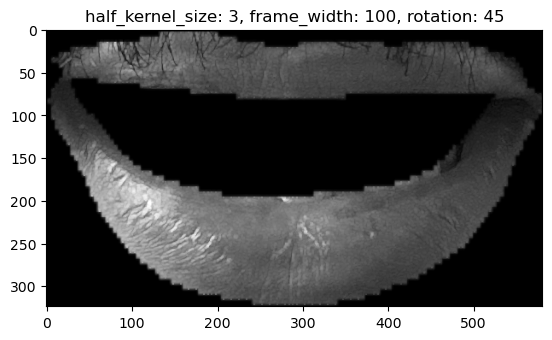

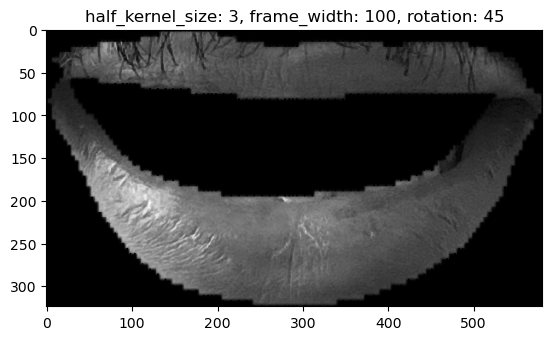

In [6]:
first_pass_image = runKernel(3, 100, 45)

In [7]:
RGBToYCbCr = np.array([[0.299, -0.169, 0.5], [0.587, -0.331, -0.419], [0.114, 0.5, -0.081]])
YCbCrToRGB = np.array([[1.0000, 1.0000, 1.0000], [-0.0009, -0.3437, 1.7721], [1.4017, -0.7142, 0.0001]])
def mix(x, y, a):
    return x * (1-a) + y * a
def secondPassKernel(
    image,
    first_pass_image,
    half_kernel_size,
    frame_width,
    rotation):

    sample_step = 1.0 / frame_width
    outputImage = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            max_of_y = 0.0
            min_of_y = 5566.0
            avg_of_cb = 0.0
            avg_of_cr = 0.0
            for k in range(-half_kernel_size, half_kernel_size + 1):
                if rotation == 0 or rotation == 180:
                    sample_shift = np.array([0.0, float(k) * sample_step])
                else:
                    sample_shift = np.array([float(k) * sample_step, 0.0])
                x = j + sample_shift[0]
                y = i + sample_shift[1]
                if x < 0 or x >= image.shape[1] or y < 0 or y >= image.shape[0]:
                    continue
                morphology_1st_pass_pixel = first_pass_image[int(y), int(x)]
                max_of_y = max(max_of_y, morphology_1st_pass_pixel[1])
                min_of_y = min(min_of_y, morphology_1st_pass_pixel[0])

                src_rgb = image[int(y), int(x)]
                src_ycbcr = np.dot(RGBToYCbCr, src_rgb)
                avg_of_cb += src_ycbcr[1]
                avg_of_cr += src_ycbcr[2]

            avg_of_cb /= (2 * half_kernel_size + 1)
            avg_of_cr /= (2 * half_kernel_size + 1)
            open_y = max_of_y
            close_y = min_of_y
            src_rgb = image[i,j]
            src_y = 0.299 * src_rgb[0] + 0.587 * src_rgb[1] + 0.114 * src_rgb[2]
            result_y = 0.0

            if close_y > src_y and open_y < src_y:
                result_y = mix(open_y, close_y, 0.5)
            elif close_y > src_y:
                result_y = mix(src_y, close_y, 0.75)
            elif open_y < src_y:
                result_y = mix(src_y, open_y, 0.5)
            else:
                result_y = mix(open_y, close_y, 0.5)
            
            src_ycbcr = np.dot(RGBToYCbCr, src_rgb)
            src_ycbcr[0] = result_y
            src_ycbcr[1] = avg_of_cb
            src_ycbcr[2] = avg_of_cr
            wrinkless_rgb = np.dot(YCbCrToRGB, src_ycbcr)
            outputImage[i, j] = wrinkless_rgb
    plt.imshow(outputImage)
    plt.title('half_kernel_size: {}, frame_width: {}, rotation: {}'.format(half_kernel_size, frame_width, rotation))
    plt.show()
    return outputImage



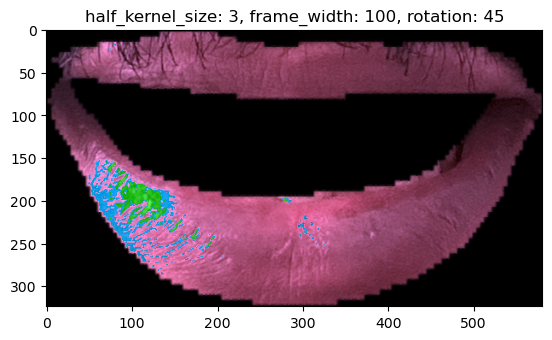

In [8]:
second_pass_image = secondPassKernel(image, first_pass_image, 3, 100, 45)

In [14]:
def thirdPassKernel(
    image,
    second_pass_image,
    half_kernel_size,
    frame_height,
    rotation,
    retouch_lip_plumper_wrinkless):

    sample_step = 1.0 / frame_height
    outputImage = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            src_dst = image[i, j]
            smoothed_morph = np.zeros(3)
            for k in range(-half_kernel_size, half_kernel_size + 1):
                if rotation == 0 or rotation == 180:
                    sample_shift = np.array([float(k) * sample_step, 0.0])
                else:
                    sample_shift = np.array([0.0, float(k) * sample_step])
                x = j + sample_shift[0]
                y = i + sample_shift[1]
                if x < 0 or x >= image.shape[1] or y < 0 or y >= image.shape[0]:
                    continue
                smoothed_morph += second_pass_image[int(y), int(x)]
            smoothed_morph /= (2 * half_kernel_size + 1)
            src_y = 0.299 * src_dst[0] + 0.587 * src_dst[1] + 0.114 * src_dst[2]
            result_y = 0.299 * smoothed_morph[0] + 0.587 * smoothed_morph[1] + 0.114 * smoothed_morph[2]
            diff_y = abs(result_y - src_y)
            threshold = 0.02
            if diff_y < threshold:
                smoothed_morph = src_dst
            outputImage[i, j] = mix(src_dst, smoothed_morph, retouch_lip_plumper_wrinkless)
    plt.imshow(outputImage)
    plt.title('half_kernel_size: {}, frame_height: {}, rotation: {}, retouch_lip_plumper_wrinkless: {}'.format(half_kernel_size, frame_height, rotation, retouch_lip_plumper_wrinkless))
    plt.show()
    # return outputImage

In [ ]:
# float protection_mask = texture2D(lipstick_mask_texture, lipstick_texcoord).r;
#     src_dst.rgb = mix(src_dst.rgb, smoothed_morph, protection_mask * retouch_lip_plumper_wrinkless * 0.01);
#     gl_FragColor = vec4(src_dst.rgb, 1.0);

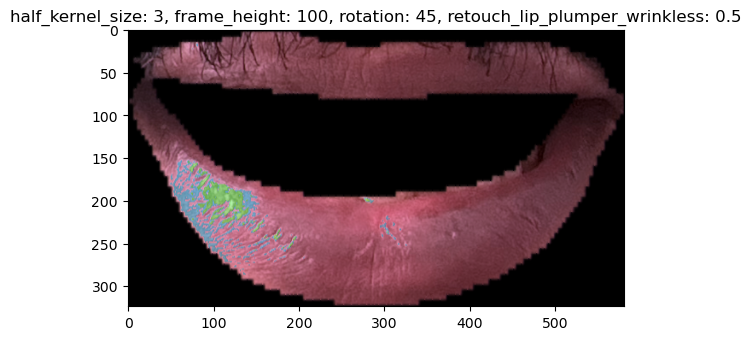

In [12]:
output = thirdPassKernel(image, second_pass_image, 3, 100, 45, 0.5)

In [15]:
interact(thirdPassKernel,
            image=fixed(image),
            second_pass_image=fixed(second_pass_image),
            half_kernel_size=widgets.IntSlider(min=0, max=10, step=1, value=5), 
            frame_height=widgets.IntSlider(min=1, max=100, step=1, value=100), 
            rotation=widgets.IntSlider(min=0, max=180, step=1, value=0),
            retouch_lip_plumper_wrinkless=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5))

interactive(children=(IntSlider(value=5, description='half_kernel_size', max=10), IntSlider(value=100, descrip…

<function __main__.thirdPassKernel(image, second_pass_image, half_kernel_size, frame_height, rotation, retouch_lip_plumper_wrinkless)>